## CS 445: Computational Photography

## Programming Project #3: Gradient Domain Fusion

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy
import scipy as sc
import scipy.sparse.linalg
from scipy.sparse import *
from scipy.sparse.linalg import lsqr
from utils import *

# modify to where you store your project data including utils.py
# datadir = "/content/drive/My Drive/cs445_projects/proj3/" 

# utilfn = datadir + "utils.py"
# !cp "$utilfn" .
# samplesfn = datadir + "samples"
# !cp -r "$samplesfn" .
import utils

## Part 1 Toy Problem (20 pts)

In [2]:
def toy_reconstruct(img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    :param toy_img: numpy.ndarray
    """

    img_h = img.shape[0]
    img_w = img.shape[1]
    #create a np array with shape of 1 * (img_h * img_w)
    im2var = np.arange(img_h * img_w)
    #reshape the single row array into the shape we want
    im2var = im2var.reshape(img_h, img_w)
#     print(im2var)
    #we use im2var to locate the pixel in original img
    
    
#     h = img_h *(img_w - 1) + (img_h - 1) * img_w+1
    h = img_h * img_w * 2 #26180
#     print("h" , h) #h 25952

    w = img_h * img_w
#     print("w" , w) #w 13090

#   A has size of :
    #h: # of formulas/constraints     
    #w: # of values we want to resolve, which is the # of pixels in our target location, which is img
    #check 5.1.3 ~13mins for more details
#     A = np.zeros([h,w])
    A = scipy.sparse.lil_matrix((h, w), dtype='double')
    b = np.zeros((A.shape[0],1), dtype = 'double')
    e = 0
    
#     A[e, im2var[y][x]] not A[e][im2var[y][x]]
    A[e, im2var[0][0]] = 1
    b[e] = img[0][0]
    e = e+1
    A[e, im2var[0][0]] = 1
    b[e] = img[0][0]
    
    print(im2var.shape)
    for y in range(img_h - 1):
        for x in range(img_w - 1):
            #copy from tips, obj1
            A[e, im2var[y][x+1]] = 1 #the coefficient for variables v, and b is the constant from original image
            A[e, im2var[y][x]] = -1
            b[e] = img[y][x+1] - img[y][x]
            e = e + 1
            #obj2
            A[e, im2var[y+1][x]] = 1
            A[e, im2var[y][x]] = -1
            b[e] = img[y+1][x] - img[y][x]
            e = e + 1
    A[e, im2var[y+1][x+1]] = 1
    b[e] = img[y+1][x+1]
    


    print("A.shape",A.shape)
    print("b.shape", b.shape)
#     A_spa = csr_matrix(A)
#     v = lsqr(A_spa, b)
    v = scipy.sparse.linalg.lsqr(A.tocsr(), b);
#https://stackoverflow.com/questions/48621407/python-equivalent-of-matlabs-lsqr-with-first-argument-a-function
#https://het.as.utexas.edu/HET/Software/Scipy/generated/scipy.sparse.linalg.lsqr.html
#     v = scipy.sparse.linalg.lsqr(A.tocsr(), b)
#     print("A_csr.shape",A_csr.shape)
#     print("A.shape",A.shape)
#     print(v)
    return v[0].reshape(img_h, img_w)
#     return img
    





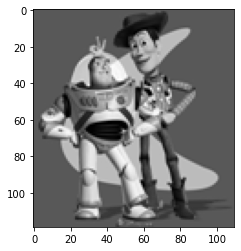

(119, 110)
A.shape (26180, 13090)
b.shape (26180, 1)


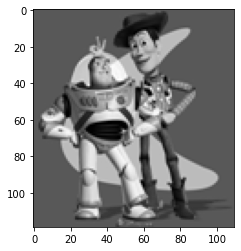

Max error is:  8.932118298277114e-06


In [3]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")
plt.show()

im_out = toy_reconstruct(toy_img)
plt.imshow(im_out, cmap="gray")
plt.show()
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

## Preparation

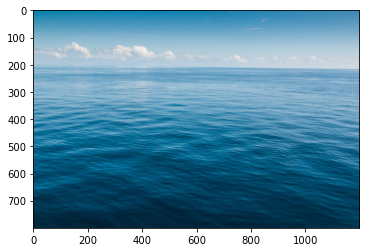

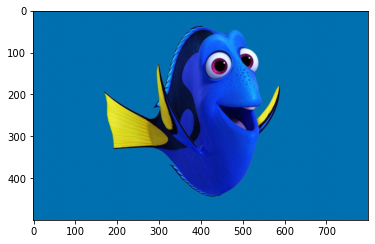

In [4]:
background_img = cv2.cvtColor(cv2.imread('samples/comb1_1.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/comb1_2.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

use_interface = True  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
    xs = (65, 359, 359, 65)
    ys = (24, 24, 457, 457)
    object_mask = utils.get_mask(ys, xs, object_img)
    bottom_center = (500, 2500) # (x,y)

    object_img, object_mask = utils.crop_object_img(object_img, object_mask)
    bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
    plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))



If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


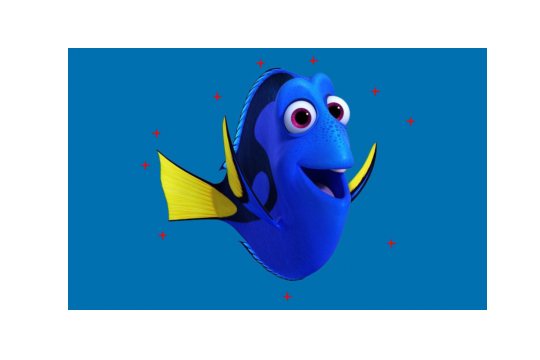

In [6]:
if use_interface:
    import matplotlib.pyplot as plt
    %matplotlib notebook
    mask_coords = specify_mask(object_img)

<Figure size 432x288 with 0 Axes>

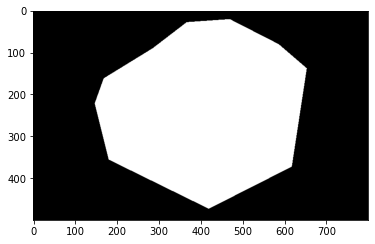

In [7]:
if use_interface:
    xs = mask_coords[0]
    ys = mask_coords[1]
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.figure()
    object_mask = get_mask(ys, xs, object_img)

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


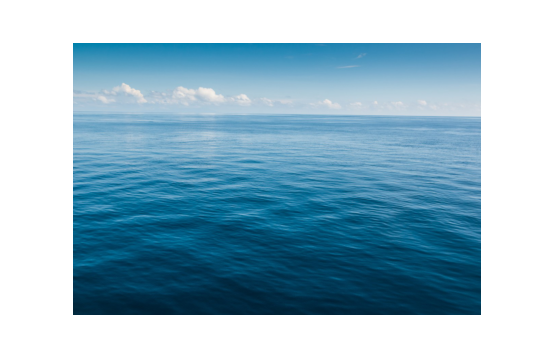

In [8]:
if use_interface:
    %matplotlib notebook
    import matplotlib.pyplot as plt
    bottom_center = specify_bottom_center(background_img)
#     bottom_center = background_img.shape[0],background_img.shape[1]


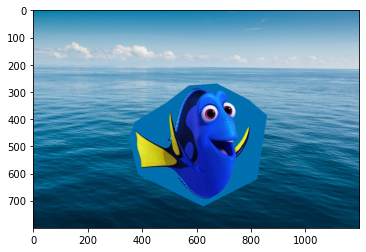

In [9]:
# print(bottom_center)
if use_interface:
    %matplotlib inline
    import matplotlib.pyplot as plt

    object_img, object_mask = utils.crop_object_img(object_img, object_mask)
    bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
    plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))
#     plt.savefig('comb3_direct.jpg')

## Part 2 Poisson Blending (50 pts)

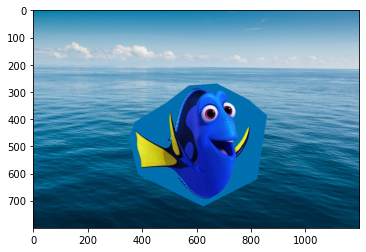

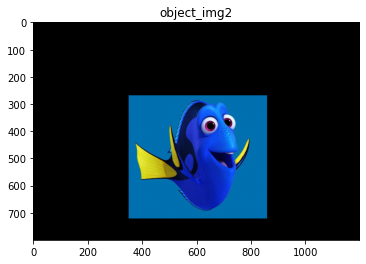

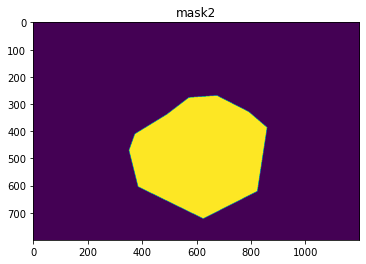

In [10]:
object_img2, mask = align_source(object_img, object_mask, background_img, bottom_center)
object_img3, mask2 = align_source(object_img, mask, background_img, bottom_center)
plt.imshow(object_img2)
plt.title('object_img2')
plt.show()
plt.imshow(mask2)
plt.title('mask2')
plt.show()

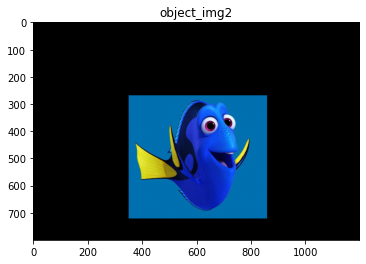

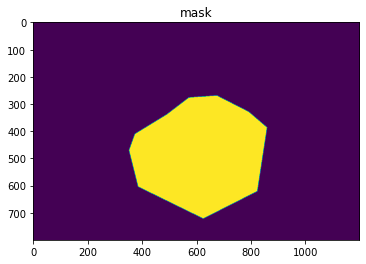

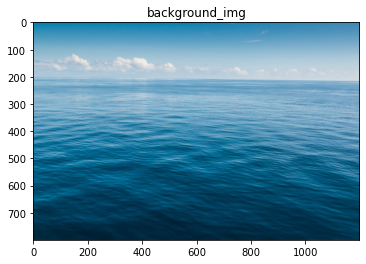

In [11]:
plt.imshow(object_img2)
plt.title("object_img2")
plt.show() 
plt.imshow(mask)
plt.title("mask")
plt.show() 
plt.imshow(background_img)
plt.title("background_img")
plt.show() 

In [12]:
def poisson_blend(object_img2, mask2, bg_img, bg_ul):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    reference:
    https://cs.brown.edu/courses/csci1950-g/results/proj2/edwallac/
    http://cs.brown.edu/courses/cs129/results/proj2/taox/
    
    """
    non_zero_x, non_zero_y = np.where(mask2 == 1)
    
    img_h = object_img2.shape[0]
    img_w = object_img2.shape[1]
    im2var = np.arange(img_h*img_w).reshape(img_h, img_w)
    result = bg_img
    e = 0
#     mask = np.nonzero(object_mask)
#     h = img_h * img_w * 4 # is this varibale setup right? does it matter?
    h = len(non_zero_x) * 4 # is this varibale setup right? does it matter?
    print(h)
    w = img_h * img_w
#     A = np.zeros((h,w), dtype = np.float64)
#     A = scipy.sparse.lil_matrix((neq, nr*nc), dtype='double') # init lil
    A = scipy.sparse.lil_matrix((h,w),dtype=np.float64)

    b = np.zeros((A.shape[0],1), dtype = np.float64)
#     print(im2var.shape)
    

    print("checkpoint 1")
#     A[e, im2var[y][x]] not A[e][im2var[y][x]]
    for y in range(img_h):
        for x in range(img_w):
            if mask2[y][x] == 0:
                continue
            else:
                result[y][x] = 0
                if mask2[y][x+1] == 1:
                    A[e, im2var[y][x+1]] = -1 
                    A[e, im2var[y][x]] = 1
                    b[e] = object_img2[y][x] - object_img2[y][x+1]
                    e = e + 1
                else:
                    A[e, im2var[y][x]] = 1
                    b[e] = object_img2[y][x] - object_img2[y][x+1] + bg_img[y][x+1]       
                    e = e + 1
###############################################################
                if mask2[y][x-1] == 1:
                    A[e, im2var[y][x-1]] = -1
                    A[e, im2var[y][x]] = 1
                    b[e] = object_img2[y][x] - object_img2[y][x-1]
                    e = e + 1
                else:
                    A[e, im2var[y][x]] = 1
                    b[e] = object_img2[y][x] - object_img2[y][x-1] + bg_img[y][x-1]       
                    e = e + 1
###############################################################       
                if mask2[y+1][x] == 1:
                    A[e, im2var[y+1][x]] = -1
                    A[e, im2var[y][x]] = 1
                    b[e] = object_img2[y][x] - object_img2[y+1][x]
                    e = e + 1
                else:
                    A[e, im2var[y][x]] = 1
                    b[e] = object_img2[y][x] - object_img2[y+1][x] + bg_img[y+1][x]       
                    e = e + 1
###############################################################
                if mask2[y-1][x] == 1:
                    A[e, im2var[y-1][x]] = -1
                    A[e, im2var[y][x]] = 1
                    b[e] = object_img2[y][x] - object_img2[y-1][x]
                    e = e + 1
                else:
                    A[e, im2var[y][x]] = 1
                    b[e] = object_img2[y][x] - object_img2[y-1][x] + bg_img[y-1][x]       
                    e = e + 1 
    print("calculating V ")
#     print(A.shape)
#     print(b.shape)
    
#computer dies while runing the A_spa and calculate v
#     A_spa = csr_matrix(A)
#     v = lsqr(A_spa, b)
    v = scipy.sparse.linalg.lsqr(A.tocsr(), b);
    print("v calculate complete")
#     print("len(v)", len(v))
#     print("len(v[0])", len(v[0])) 

    result = result + v[0].reshape(img_h, img_w)
                

    
#     return v[0].reshape(img_h, img_w)
    return result
    




648004
checkpoint 1
calculating V 
v calculate complete
648004
checkpoint 1
calculating V 
v calculate complete
648004
checkpoint 1
calculating V 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


v calculate complete


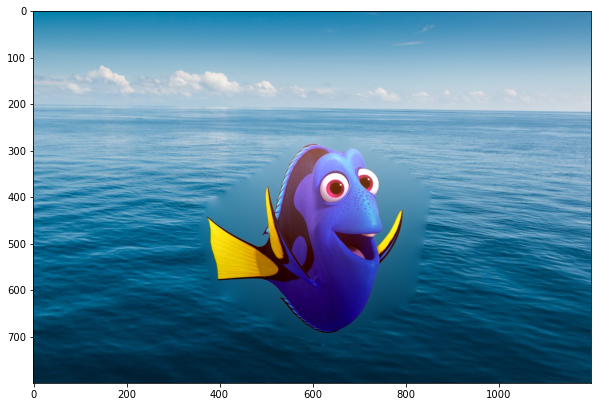

In [13]:
im_blend = np.zeros(background_img.shape)
# plt.imshow(mask2)
# plt.title('mask2')
# plt.show()
# plt.imshow(background_img)
# plt.title('background_img')
# plt.show()
# plt.imshow(object_img2)
# plt.title('object_img2')
# plt.show()

for b in np.arange(3):
    im_blend[:,:,b] = poisson_blend(object_img2[:,:,b], mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(10,10))
plt.imshow(im_blend)

# plt.savefig('comb3_poi.jpg')

## Part 3 Mixed Gradients (20 pts)

In [15]:
def greater(input1, input2):
    if abs(input1) > abs(input2):
        return input1
    else:
        return input2
print(greater(-20, 9))

-20


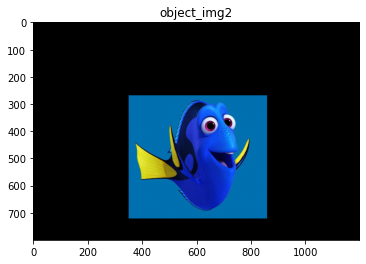

In [16]:
plt.imshow(object_img2)
plt.title('object_img2')
plt.show()

In [17]:
def mixed_blend(object_img2, mask2, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    non_zero_x, non_zero_y = np.where(mask2 == 1)
    
    img_h = object_img2.shape[0]
    img_w = object_img2.shape[1]
    im2var = np.arange(img_h*img_w).reshape(img_h, img_w)
#     result = bg_img
    result = np.zeros((bg_img.shape),dtype='double')
    result = (1-mask2) * bg_img
    
    e = 0
#     mask = np.nonzero(object_mask)
    h = len(non_zero_x) * 4 

    w = img_h * img_w
    A = scipy.sparse.lil_matrix((h,w),dtype=np.float64)
    b = np.zeros((A.shape[0],1), dtype = np.float64)

    print("checkpoint 1")
    for y in range(img_h):
        for x in range(img_w):
            if mask2[y][x] == 0:
                continue
            else:
#                 result[y][x] = 0

                

                if mask2[y][x+1] == 1:
                    A[e, im2var[y][x+1]] = -1 
                    A[e, im2var[y][x]] = 1
#                     b[e] = object_img2[y][x] - object_img2[y][x+1]
                    b[e] = compare(object_img2[y][x] - object_img2[y][x+1], bg_img[y][x] - bg_img[y][x+1])
                    e = e + 1
                else:
                    A[e, im2var[y][x]] = 1
#                     b[e] = object_img2[y][x] - object_img2[y][x+1] + bg_img[y][x+1]  
                    b[e] = compare(object_img2[y][x] - object_img2[y][x+1], bg_img[y][x] - bg_img[y][x+1]) + bg_img[y][x+1]       
                    e = e + 1
###############################################################
                if mask2[y][x-1] == 1:
                    A[e, im2var[y][x-1]] = -1
                    A[e, im2var[y][x]] = 1
                    b[e] = object_img2[y][x] - object_img2[y][x-1]
#                     b[e] = compare(object_img2[y][x] - object_img2[y][x-1],bg_img[y][x] - bg_img[y][x-1])
                    e = e + 1
                else:
                    A[e, im2var[y][x]] = 1
#                     b[e] = object_img2[y][x] - object_img2[y][x-1] + bg_img[y][x-1]
                    b[e] = compare(object_img2[y][x] - object_img2[y][x-1],bg_img[y][x] - bg_img[y][x-1]) + bg_img[y][x-1]       
                    e = e + 1
###############################################################       
                if mask2[y+1][x] == 1:
                    A[e, im2var[y+1][x]] = -1
                    A[e, im2var[y][x]] = 1
                    
                    b[e] = compare(object_img2[y][x] - object_img2[y+1][x], bg_img[y][x] - bg_img[y+1][x])
                    e = e + 1
                else:
                    A[e, im2var[y][x]] = 1
                    b[e] = compare(object_img2[y][x] - object_img2[y+1][x], bg_img[y][x] - bg_img[y+1][x]) + bg_img[y+1][x]       
                    e = e + 1
###############################################################
                if mask2[y-1][x] == 1:
                    A[e, im2var[y-1][x]] = -1
                    A[e, im2var[y][x]] = 1
                    b[e] = compare(object_img2[y][x] - object_img2[y-1][x],bg_img[y][x] - bg_img[y-1][x])
                    e = e + 1
                else:
                    A[e, im2var[y][x]] = 1
                    b[e] = compare(object_img2[y][x] - object_img2[y-1][x], bg_img[y][x] - bg_img[y-1][x]) + bg_img[y-1][x]       
                    e = e + 1 
    print("calculating V ")
#     print(A.shape)
#     print(b.shape)
    

    v = scipy.sparse.linalg.lsqr(A.tocsr(), b);
    print("v calculate complete")
    result = result + v[0].reshape(img_h, img_w)
    return result

checkpoint 1
calculating V 
v calculate complete
checkpoint 1
calculating V 
v calculate complete
checkpoint 1
calculating V 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


v calculate complete


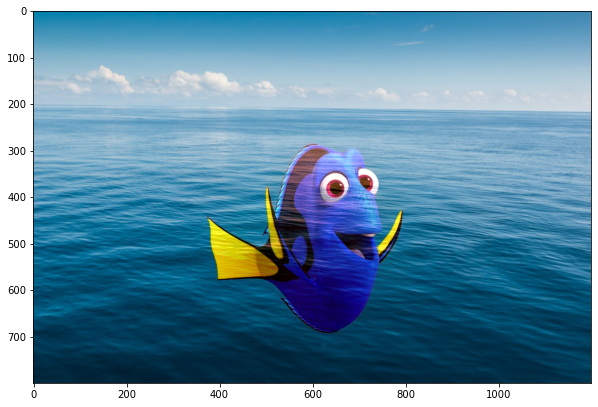

In [18]:
im_mix = np.zeros(background_img.shape)
for b in np.arange(3):
    im_mix[:,:,b] = mixed_blend(object_img2[:,:,b], mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(10,10))
plt.imshow(im_mix)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [ ]:
def color2gray(img):
    pass

## Laplacian pyramid blending (20 pts)

In [ ]:
def laplacian_blend(object_img, object_mask, bg_img, bg_ul):
  # feel free to change input parameters
    pass

## More gradient domain processing (up to 20 pts)